In [1]:
%matplotlib inline
import os, json
# os.environ["CUDA_VISIBLE_DEVICES"]=""
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycococreatortools import pycococreatortools
from icevision import models, parsers, show_records, tfms, Dataset, Metric, COCOMetric, COCOMetricType
from icevision.imports import *
from icevision.utils import *
from icevision.data import *
from icevision.metrics.metric import *
from sklearn.metrics import confusion_matrix, f1_score
import skimage.io as skio
from ceruleanml.coco_stats import all_sample_stat_lists
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from ceruleanml import preprocess
from ceruleanml import data

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /root/.icevision/mmdetection_configs/mmdetection_configs-2.20.1/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17
INFO     - The mmseg config folder already exists. No need to downloaded it. Path : /root/.icevision/mmsegmentation_configs/mmsegmentation_configs-0.17.0/configs | icevision.models.mmseg.download_configs:download_mmseg_configs:19


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
bs_d ={512:14, 256:28, 224:28, 128:50, 64:128} # Batch Size for each image size
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2} # Learning Rate for each image size
# the timeings below are safe on a T4. spikes in gpu mem for smaller im sizes 
# with large batch size cause OOM. 34 bs for 224 for example
mins_d = {512:5.01, 256:3.1, 224:3.1, 128:2.5, 64:1.6} 
run_list = [[64, 20]]*10+[[128, 20]]*8+[[224, 20]]*6 +[[512, 20]]*3 # List of tuples, where the tuples are [px size, training time in minutes]
# run_list = [[64, 1]]*1+[[128, 1]]*1+[[224, 1]]*1 +[[512, 1]]*1
init_size = run_list[0][0]
fp16 = False
n = "all"
arch = 34
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 0
# this doesn't work with icevision models yet because icevision does 
# use the class_map to set the expected classes, the shape of the model head
# unlike the fastai trainer. need to use loss to ignore ambiguous or reset class_map but
# class map is immutable with pop or del
# remap_dict = { 
#     "ambiguous": None,
# }
num_classes = 7 # since we remove ambiguous and include background

model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet34_fpn
# causes kernel death without any CUDA out of memory error or traceback aftr training for a while
# model_type = models.mmdet.mask_rcnn
# backbone = model_type.backbones.mask_rcnn_swin_t_p4_w7_fpn_1x_coco

### Important! 

Make sure you have copied the dataset to the local SSD of the VM at /root. Loading the data from a GCP bucket takes a full 2 minutes compared to 17 seconds when data is on the SSD.

You can run the following for example to copy a dataset from the bucket to the vm quickly.

```
mkdir tile-cerulean-v2-partial-with-context
gsutil -m rsync -ravzp gs://ceruleanml/tile-cerulean-v2-partial-with-context tile-cerulean-v2-partial-with-context
```

In [4]:
data_path = "/root/"
mount_path = "/root/data"

In [5]:
### Parsing COCO Dataset with Icevision

mount_path = "/root/"
train_set = "train-with-context-512"
tiled_images_folder_train = "tiled_images"
json_name_train = "instances_TiledCeruleanDatasetV2.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-with-context-512"
tiled_images_folder_val= "tiled_images"
json_name_val = "instances_TiledCeruleanDatasetV2.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

class_map = {v: k for k, v in data.class_mapping_coco_inv.items()}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df

record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False, remap_dict = {"ambiguous": None}
)
record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False, remap_dict = {"ambiguous": None}
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

  0%|          | 0/3863 [00:00<?, ?it/s]

100%|██████████| 3014/3014 [00:00<00:00, 118015.95it/s]


  0%|          | 0/352 [00:00<?, ?it/s]

100%|██████████| 266/266 [00:00<00:00, 126480.54it/s]


In [6]:
# %matplotlib inline
# show_records(record_collection_with_negative_small_filtered_train[0:2], ncols=3, class_map=class_map, display_mask=True, display_bbox=False)

In [7]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])
train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])

sourced from: https://airctic.com/0.8.1/getting_started_instance_segmentation/

## custom iou metric because of -1 error

In [12]:
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback
train_ds = Dataset(record_collection_with_negative_small_filtered_train, train_tfms)
valid_ds = Dataset(record_collection_with_negative_small_filtered_val, valid_tfms)
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=6, shuffle=True) # adjust num_workers for your processor count
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, num_workers=6, shuffle=False)
infer_dl = model_type.infer_dl(valid_ds, batch_size=32, shuffle=False)
# metrics = [IoUMetric(metric_type=IoUMetricType.mask)]

model = model_type.model(backbone=backbone(pretrained=True), num_classes=num_classes)
learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, cbs=[TensorBoardCallback(projector=False, trace_model=False)]) # cbs=SaveModelCallback(monitor='COCOMetric')

running_total_epochs = {}

1 train epoch is about 4 minutes. 1 validation epoch of 76 samples is also about a minute.

# No Progressive Resize

In [9]:
#learner.fine_tune(35, 3e-3) # 3e-3 is hand selected lr
# learn.fine_tune(2, lr.valley) #, freeze_epochs=2)

## Progressive Resizing

In [ ]:
from icevision.models.utils import get_dataloaders
from icevision.engines.fastai import convert_dataloaders_to_fastai


for size, total_train_time in run_list:
    epochs = max(int(total_train_time/mins_d[size]), 1)
    bs = bs_d[size]
    lr = lr_d[size]
    valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size)])
    train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size)])
    ds, dls = get_dataloaders(model_type, [record_collection_with_negative_small_filtered_train, record_collection_with_negative_small_filtered_val], [train_tfms, valid_tfms], batch_size=bs, num_workers=8)
    fastai_dls = convert_dataloaders_to_fastai(dls=dls)
    learner.dls = fastai_dls
    print(f"Training time is: {total_train_time} minutes")
    print("starting from running total", running_total_epochs)
    print("image size", size)
    print("batch size", bs)
    print("arch", arch)
    print("lr", lr)
    print("n chips", n)
    print("context")
    print("epochs", epochs)
    print("num_classes", num_classes)

    learner.fine_tune(epochs, lr, freeze_epochs=0) # cbs=cbs

    running_total_epochs[size] = sum(filter(None,[running_total_epochs.get(size),epochs]))

Training time is: 20 minutes
starting from running total {}
image size 64
batch size 128
arch 34
lr 0.01
n chips all
context
epochs 12
num_classes 7


epoch,train_loss,valid_loss,time


/root/work/.ice-env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Instance Evaluation

Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plotting the VV only
Channels is 3 but plottin

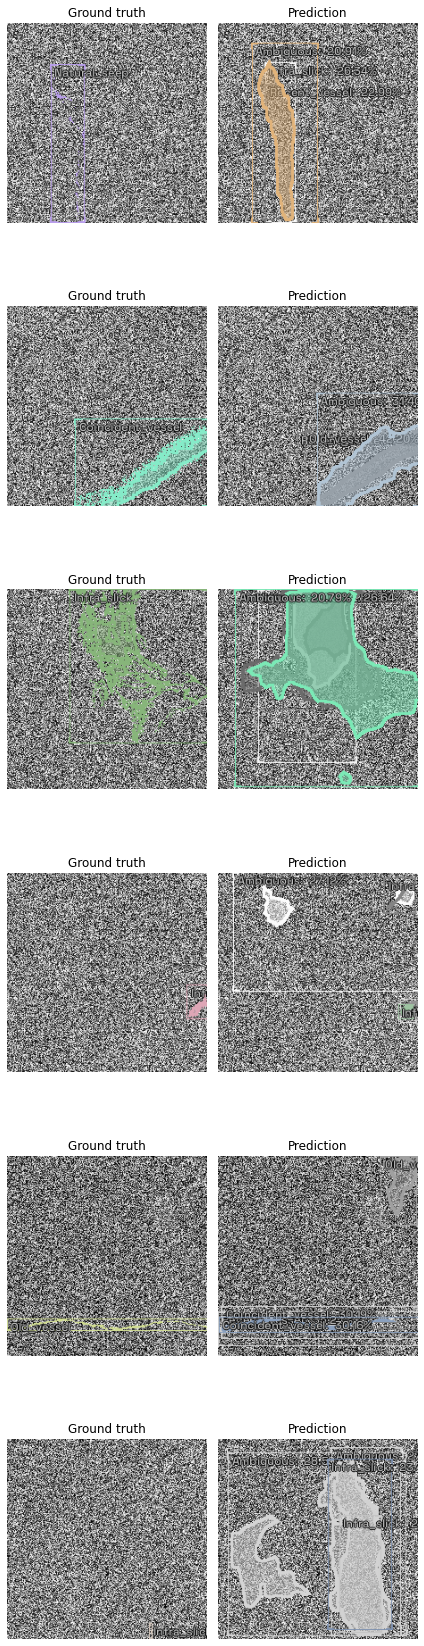

In [20]:
model_type.show_results(model, valid_ds, detection_threshold=.2)

In [ ]:
!mkdir {mount_path}/experiments/cv2/05062022_ep10

In [ ]:
from ceruleanml.inference import save_fastai_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes
save_template = f'test_{bs}_{arch}_{size}_{round(validation[1],3)}_{epochs}.pt'
state_dict_pth, tracing_model_gpu_pth, tracing_model_cpu_pth  = save_fastai_model_state_dict_and_tracing(learner, dls, save_template, experiment_dir)

In [ ]:
model = torch.jit.load(tracing_model_cpu_pth)

The predictions above .7 confidence that roughly line up with groundtruth demonstrates that icevision-trained models can produce predictions that look like they are headed in the correct direction, even for an imperfect training set.

In [ ]:
x = model_type.show_results(model, valid_ds, detection_threshold=.6) 
plt.savefig("inference_results.png")

In [ ]:
preds = model_type.predict_from_dl(model, infer_dl, keep_images=True)

In [ ]:
d = preds[10].as_dict()

In [ ]:
d

In [ ]:
v = valid_records[10].as_dict()

In [ ]:
v

In [ ]:
v_masks = v['detection']['masks'] #[0].to_mask(d['common']['height'],d['common']['width']).data

In [ ]:
d_masks = d['detection']['masks'] #[0].to_mask(d['common']['height'],d['common']['width']).data

In [ ]:
# flatten our mask arrays and use scikit-learn to create a confusion matrix
flat_preds = np.concatenate(d_masks).flatten()
flat_truth = np.concatenate(v_masks).flatten()
OUTPUT_CHANNELS = 6
cm = confusion_matrix(flat_truth, flat_preds, labels=list(range(OUTPUT_CHANNELS)))

classes = [1,2,3,4,5,6]

#%matplotlib inline
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)
# We want to show all ticks...
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=list(range(OUTPUT_CHANNELS)), yticklabels=list(range(OUTPUT_CHANNELS)),
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f' #'d' # if normalize else 'd'
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], fmt),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")
fig.tight_layout(pad=2.0, h_pad=2.0, w_pad=2.0)
ax.set_ylim(len(classes)-0.5, -0.5)

plt.savefig(f'{ROOT_DIR}cm.png')


# compute f1 score
f1 = f1_score(flat_truth, flat_preds, average='macro')

print("cm: ", cm)
print("f1: ", f1)


# Tips

* `nvidia-smi -lms` reports at millisecond frequency and can reveal big gpu spikes
* a TODO is to debug the COCOMetric, it should not be -1 given that we are now acheiving detections that intersect with groundtruth. It's documented in icevision issues that the COCOMetric doesn't work for torchvision models because of a bounding box coordinate conversion error. They say it works for mmdet but mmdet does not support negative samples and was erroring saying there were negative samples even when none were included and no data transformations were done.
* for the icevision trainer, class mismatch from preprocess remap causes long pauses then training failure. restarting kernel causes . reboot causes driver removal and need to redeploy